## Keras

Keras это высокоуровневая обертка над tensorflow. Но в текущих реализациях библиотеке tf они живут очень рядом. 
Когда мы собираем свои нейронки мы берем уже готовые слои из keras и добавляем что-то свое, если нам требуется.
Но keras можно использовать без явного использования TF пытаясь свести задачу к fit-predict.


### Sequential
Самое простое, что мы можем сделать это собирать слои последовательно друг за другом - займеся же этим!

In [1]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, layers as L # подгружаем нужные модули. 
import tensorflow.keras as keras

In [2]:
# в keras лежит несколько наборов данных. Для примера возьмем fashion_mnist - как mnist, но про предметы одежды :)
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

X_train = X_train/ 255.
X_val = X_val/ 255.
X_test = X_test/ 255.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# для того, чтобы учить через cross_entropy нам нужно сделать OHE таргетам. И эта функция есть в keras!
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)


In [5]:
## Первая простая нейронка

tf.random.set_seed(42) # фиксируем random_seed

model = Sequential(name = 'first_try')
model.add(L.Input(shape = (28,28))) # входной нейрон с данными. Его обычно можно опускать, сразу передавая 
# в нейрон размерность. Но Dense ячейки не умеют работать с картинками, поэтому оставляем Input
model.add(L.Flatten()) # разворачиваем картинку в вектор
model.add(L.Dense(100,  kernel_initializer='random_normal',name='First')) 
# можно именовать и потом брать слои по именам
model.add(L.ReLU()) # добавляем активацию
model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output'))
model.add(L.Softmax())
opt = keras.optimizers.Adam(learning_rate=1e-4) # так же нам нужно указать оптимайзер
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) # и собрать нашу модель, указав метрики,loss и оптимизатор


history1 = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe))
# и процесс обучения. Задаем количество эпох, размер батча и валидационную часть наших данных


Epoch 1/2
100/100 [==============================] - 2s 11ms/step - loss: 2.1116 - categorical_accuracy: 0.3111 - val_loss: 1.4741 - val_categorical_accuracy: 0.6431
Epoch 2/2
100/100 [==============================] - 1s 6ms/step - loss: 1.3174 - categorical_accuracy: 0.6553 - val_loss: 1.0262 - val_categorical_accuracy: 0.6838


In [6]:
history1.params

{'verbose': 1, 'epochs': 2, 'steps': 100}

In [7]:
history1.history

{'loss': [1.8980991840362549, 1.2028253078460693],
 'categorical_accuracy': [0.4696600139141083, 0.6652799844741821],
 'val_loss': [1.4740629196166992, 1.0262092351913452],
 'val_categorical_accuracy': [0.6431000232696533, 0.6837999820709229]}

In [7]:
# Эту же модель можно записать чуть в меньшее количество строчек кода
model = Sequential(name = 'first_try')
model.add(L.Input(shape = (28,28))) 
model.add(L.Flatten()) 
model.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu')) 
# можно именовать и потом брать слои по именам
model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-4) 
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

history1 = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe))


Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 1s 15us/sample - loss: 1.8141 - categorical_accuracy: 0.4979 - val_loss: 1.3973 - val_categorical_accuracy: 0.6449
Epoch 2/2
50000/50000 [==============================] - 0s 8us/sample - loss: 1.1440 - categorical_accuracy: 0.6720 - val_loss: 0.9782 - val_categorical_accuracy: 0.6839


In [9]:
# ?L.Dense

Из приятного - все в таком подходе можно кастомизировать под себя!
Но пока продолжим рассмотрение о следующем подходе сборки моделей.
Класс Sequential не дает нам вообще никакой гибкости, позволяя набирать слои только последовательно.
Что же у нас есть новый герой  - Model.
Он позволяет собирать сетки практически любой архитектуры

In [10]:
from tensorflow.keras import Model  # подгружаем нужные модули. 

In [11]:
init = 'uniform'
act = 'relu'

input_tensor = L.Input(shape=(28, 28)) # задаем вход
x = L.Flatten()(input_tensor)# применение нейрона к входу
x = L.Dense(100, kernel_initializer=init, activation=act)(x) # повторяем всю логику сколько нам надо
x = L.Dense(100, kernel_initializer=init, activation=act)(x)
output_tensor = L.Dense(10, kernel_initializer=init, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor) # Keras под копотом сам собирает граф.
# Если он может получить из входа выхода то вы великолепны.

model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe))

Epoch 1/2
100/100 [==============================] - 1s 8ms/step - loss: 2.0566 - categorical_accuracy: 0.3674 - val_loss: 1.1507 - val_categorical_accuracy: 0.6225
Epoch 2/2
100/100 [==============================] - 1s 6ms/step - loss: 1.0285 - categorical_accuracy: 0.6415 - val_loss: 0.8508 - val_categorical_accuracy: 0.6740


Такой подход позволяет делать практически любой гибкости нейронки. Как пример - двухголовая!

In [14]:
input_1 = L.Input(shape=(28, 28))
input_2 = L.Input(shape=(28, 28))

x1 = L.Flatten()(input_1)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x1)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x1)

x2 = L.Flatten()(input_2)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x2)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x2)

x = L.concatenate([x1, x2]) # Волшебное слово, которое позволяет нам соеденять несколько потоков наших данных
output = L.Dense(10, kernel_initializer=init, activation='softmax')(x)

model = keras.Model([input_1, input_2], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_4[0][0]                    
____________________________________________________________________________________________

In [25]:
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [27]:
history = model.fit([X_train,X_train],y_train_ohe,batch_size=500,epochs=2,validation_data = ([X_val,X_val],y_val_ohe))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 1s 22us/sample - loss: 1.3714 - categorical_accuracy: 0.6164 - val_loss: 0.8260 - val_categorical_accuracy: 0.6711
Epoch 2/2
50000/50000 [==============================] - 1s 14us/sample - loss: 0.7213 - categorical_accuracy: 0.7305 - val_loss: 0.6702 - val_categorical_accuracy: 0.7558


In [15]:
# # нужно для винды, если не видит путь до graphviz
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.utils import plot_model


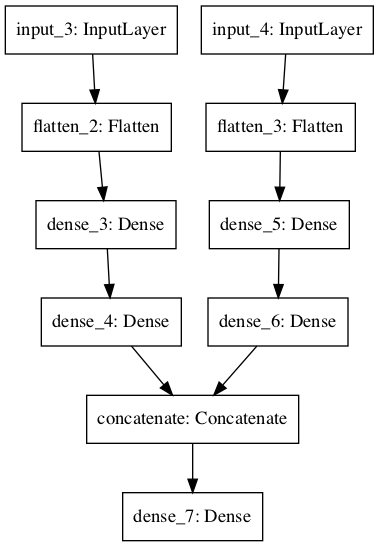

In [16]:
plot_model(model) # можно нарисовать модельку

## 4.2 Несколько выходов и функций потерь

In [18]:
init = 'uniform'
act = 'relu'

input_tensor = L.Input(shape=(28, 28))

x = L.Flatten()(input_tensor)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x)
x3 = L.Dense(100, kernel_initializer=init, activation=act)(x)

output_1 = L.Dense(1, kernel_initializer=init, activation='sigmoid',name='gender')(x1)
output_2 = L.Dense(10, kernel_initializer=init, activation='softmax',name='income')(x2)
output_3 = L.Dense(1, kernel_initializer=init,name='age')(x3)

model = keras.Model(input_tensor, [output_1, output_2, output_3])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 784)          0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 100)          78500       flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          78500       flatten_5[0][0]                  
____________________________________________________________________________________________

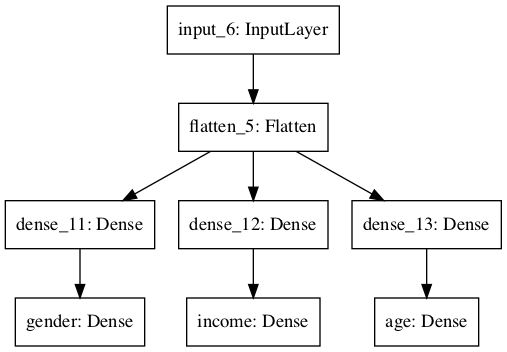

In [19]:
plot_model(model) # можно нарисовать модельку

In [21]:
# чтобы модель не переобучилась под самую большую функцию потерь
# их можно взвесить
model.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
                                    loss_weights=[0.25, 1., 10.])


# если дали выходам имена, можно вот так: 

model.compile(optimizer='adam',

              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
                    
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

Помните статью про то, как люди рисовали функции потерь? [Теперь появилась галерея!](https://losslandscape.com/gallery/) Есть подход как skip-connection, он сильно меняет нашу функцию.

![](https://i.stack.imgur.com/UDvbg.png)

Такую модель нельзя собрать через `Sequence`-стиль, но можно через функциональный стиль. Давайте попробуем сделать это. Заодно посмотрим насколько сильно в нашей ситуации будет меняться траектория обучения. (Сравним обычный 6-ти слойный персептрон и с прокидыванием инфы, например со 2 слоя на 5ый). Ну и также сразу поэксперементируем с функциями активаций и batchnorm.

# ДОМАШНЯЯ РАБОТА

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ  создайте сеть по инструкциям ниже
tf.random.set_seed(42)
## Соберите обычный 6ти слойный перспептрон



In [ ]:
## Соберите обычный 6ти слойный перспептрон с функциями активации сигмоид


In [ ]:
## Соберите с батчнормом и релу


In [ ]:
## Соберите ну и наконец прокидывание данных


In [28]:
# Функция для удобной отрисовки всего

def plot_history(histories, key='loss', start=0):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch[start:], history.history['val_'+key][start:],
                       #'--', 
                       label=name.title()+' Val')
            #plt.plot(history.epoch[start:], history.history[key][start:], color=val[0].get_color(),
            #     label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([start, max(history.epoch)])


In [ ]:
plot_history([('simple',    history_simple), 
              ('simple_sigmoid', history_simple_sigmoid),
              ('simple_BN_and_init', history_simple_BN_and_init),
              ('complex!!!',   history_complex)
             ],
             start=0)

#### Более интересная часть - кастомизация
В keras уже есть несколько удобных callback.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint

In [31]:
EarlyStopping # останавливает обучение если наша метрика не меняет n эпох
LearningRateScheduler # меняет наш learning_rate по расписанию
ReduceLROnPlateau # понижает на LR если не происходит улучшения
ModelCheckpoint # сохраняет нашу лучшую модель

tensorflow.python.keras.callbacks.ModelCheckpoint

In [21]:
early_stop = EarlyStopping(patience=3)
reduce_on_plateau = ReduceLROnPlateau(patience=3)
# filepath="checkpoint_path/weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="checkpoint_path/weights-improvement.hdf5"
model_checkpoing = ModelCheckpoint(filepath,
                                   save_best_only=True,
                                  save_weights_only=True)

In [22]:
def create_simple_model():
    model = Sequential(name = 'simple_model')
    model.add(L.Input(shape = (28,28))) 
    model.add(L.Flatten()) 
    model.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu'))
    model.add(L.Dense(100,  kernel_initializer='random_normal',name='Second',activation='relu'))
    model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=1e-4) 
    model.compile(optimizer=opt,loss='categorical_crossentropy',
                 metrics=["categorical_accuracy"]) 
    return model


In [24]:
!mkdir checkpoint_path

In [25]:

model = create_simple_model()

history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau,model_checkpoing],verbose=0)


In [44]:
model.load_weights('checkpoint_path/weights-improvement.hdf5')

In [26]:
filepath="checkpoint_path/full_model_improvement.hdf5"
model_checkpoing = ModelCheckpoint(filepath,
                                   save_best_only=True,
                                  save_weights_only=False)
simple_model = create_simple_model()

history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau,model_checkpoing],verbose=0)


In [27]:
simple_model = keras.models.load_model(filepath)

In [28]:
simple_model.evaluate(x=X_val,y=y_val_ohe)

313/313 [==============================] - 1s 1ms/step - loss: 0.4328 - categorical_accuracy: 0.8472


[0.4327818751335144, 0.8471999764442444]

In [63]:
from tensorflow.keras import callbacks
 
class My_Callback(callbacks.Callback):     # Класс My_Callback унаследовал свойства класса Callback
    def on_train_begin(self, logs={}):           # Функция, которая выполняется в начале обучения 
        return
 
    def on_train_end(self, logs={}):             # Функция, которая выполняется в конце обучения 
        return
 
    def on_epoch_begin(self, logs={}):           # В начале каждой эпохи 
        return
 
    def on_epoch_end(self, epoch, logs={}): 
        # В конце каждой эпохи
        return
 
    def on_batch_begin(self, batch, logs={}):    # В начале батча
        return
 
    def on_batch_end(self, batch, logs={}):      # В конце батча 
        return

In [29]:
from tensorflow.keras import callbacks

class Printlogs(callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch==10:
            print(logs)
        

In [30]:
simple_model = create_simple_model()
our_callback = Printlogs()

In [31]:
history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [our_callback],
                           verbose=0)

{'loss': 0.4888562560081482, 'categorical_accuracy': 0.8313199877738953, 'val_loss': 0.5013513565063477, 'val_categorical_accuracy': 0.8269000053405762}


In [32]:
import numpy as np
# Напишем изменение скорости обучения
INIT_LR=0.1
# Стратегия для понижения скорости
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 1.0
    lrate = INIT_LR * np.math.pow(drop, np.math.floor((epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(lr_scheduler)
# класс чтобы отслеживать бесчинства
class Print_lr(callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(float(tf.keras.backend.get_value(self.model.optimizer.lr)))
        # чтобы установить свой LR надо указать
        # LR_OUR = ....
#         tf.keras.backend.set_value(self.model.optimizer.lr, LR_OUR)


simple_model = create_simple_model()
history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [lrate,Print_lr()],
                           verbose=0)


0.10000000149011612
0.05000000074505806
0.02500000037252903
0.012500000186264515
0.0062500000931322575
0.0031250000465661287
0.0015625000232830644
0.0007812500116415322
0.0003906250058207661
0.00019531250291038305
9.765625145519152e-05
4.882812572759576e-05
2.441406286379788e-05
1.220703143189894e-05
6.10351571594947e-06
3.051757857974735e-06
1.5258789289873675e-06
7.629394644936838e-07
3.814697322468419e-07
1.9073486612342094e-07


In [40]:
# Давайте заставим модель посчитать метрики каждую эпоху, как пример
# Считать будем на X_val, y_val


class OUR_CALLBACK(callbacks.Callback):
    def __init__(self,X_val,y_val):
        super(callbacks.Callback).__init__()
        self.X_val = X_val
        self.y_val = y_val
    def on_epoch_end(self, epoch, logs):
        self.preds = self.model.predict(X_val)
        self.metrics_value = tf.reduce_mean(tf.keras.metrics.categorical_crossentropy(y_val_ohe,
                                                                                      self.preds )).numpy()
        print(self.metrics_value)
        
        # чтобы установить свой LR надо указать
        # LR_OUR = ....
#         tf.keras.backend.set_value(self.model.optimizer.lr, LR_OUR)

In [41]:
our_callback = OUR_CALLBACK(X_val,y_val)

In [42]:
simple_model = create_simple_model()
history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [our_callback],
                           verbose=0)

1.5499213
0.9714457
0.7887423
0.6969125
0.63916534
0.5977321
0.568815
0.5447291
0.5252664
0.51107293
0.49687314
0.48725587
0.47686234
0.4683497
0.46307877
0.4561717
0.44980127
0.44555038
0.44013345
0.43474877


<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481],
       [0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481],
       [0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481],
       ...,
       [0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481],
       [0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481],
       [0.09976298, 0.09998395, 0.09995144, ..., 0.10121609, 0.10007522,
        0.09990481]], dtype=float32)>

### Кастомные loss и метрики
Что уже есть
https://keras.io/api/metrics/

https://keras.io/api/losses/

In [43]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype=float)
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype=float)

In [44]:


model = Sequential()
model.add(L.Dense(1))

opt = tf.keras.optimizers.Adam( )

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=3, verbose=1)



Epoch 1/3
1/1 [==============================] - 0s 229ms/step - loss: 2647.7888
Epoch 2/3
1/1 [==============================] - 0s 10ms/step - loss: 2645.7793
Epoch 3/3
1/1 [==============================] - 0s 11ms/step - loss: 2643.7717


In [45]:
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [46]:
%%time
model = Sequential()
model.add(L.Dense(1))

opt = tf.keras.optimizers.Adam( )

model.compile(loss=custom_loss_function, optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=3,verbose=1)



Epoch 1/3
1/1 [==============================] - 0s 301ms/step - loss: 2484.2773
Epoch 2/3
1/1 [==============================] - 0s 6ms/step - loss: 2482.3665
Epoch 3/3
1/1 [==============================] - 0s 3ms/step - loss: 2480.4568
CPU times: user 335 ms, sys: 11.3 ms, total: 347 ms
Wall time: 477 ms


In [97]:
## тоже самое можно делать и с метриками. Также можно следить сразу за несколькими метриками, что бывает полезно.
## Если хотим добавить совсем сложную логику то мы это будем делать через callback

В этой тетрадке немного поработаем с градусами по цельсию и фаренгейту! Снова попробуем восстановить формулу 

$$ f = c \times 1.8 + 32 $$

In [54]:
## возьмем срезы
tf.keras.backend.set_floatx('float64')
model = Sequential()
model.add(L.Dense(1,name='our_neural'))

opt = tf.keras.optimizers.Adam(0.1 )

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=600, verbose=0)



In [52]:
## элементарная задача, но из-за того, что данные не скалированы сходились вечность
our_layer = model.get_layer(name='our_neural')
our_layer.variables

[<tf.Variable 'our_neural/kernel:0' shape=(1, 1) dtype=float64, numpy=array([[-1.20632126]])>,
 <tf.Variable 'our_neural/bias:0' shape=(1,) dtype=float64, numpy=array([0.09979228])>]

In [61]:
1-1.8/our_layer.variables[0].numpy()[0][0]<0.05

False

In [73]:
class OUR_CALLBACK(callbacks.Callback):
    epsilon = 0.05
    k = 1.8
    stop = True
    
    # взять вес из модели который отвечает за наклон
    # сравнить его с эталоном
    # записать точку остановки

    def on_epoch_end(self, epoch, logs):
        our_k = self.model.get_layer(name='our_neural').variables[0].numpy()[0][0]
        if abs(1-self.k/our_k)<self.epsilon and self.stop:
            self.end_learning = epoch
            self.final_k = our_k
            self.stop = False
        


In [76]:
our_call_1 = OUR_CALLBACK()
our_call_2 = OUR_CALLBACK()
## возьмем срезы
tf.keras.backend.set_floatx('float64')
model = Sequential()
model.add(L.Dense(1,name='our_neural'))

opt = tf.keras.optimizers.Adam(0.01 )

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=600, verbose=0,callbacks = [our_call_1])

In [77]:
our_call_1.end_learning

424

In [78]:
model = Sequential()
model.add(L.BatchNormalization())
model.add(L.Dense(1,name='our_neural'))

opt = tf.keras.optimizers.Adam(0.01 )

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=600, verbose=0,callbacks = [our_call_2])

In [79]:
our_call_2.end_learning

1

In [80]:
our_call_2.final_k


1.7143402792814162

 Есть понимание, как взять определить в callback на какой эпохе мы получили правильное значение весов? Проверить как ведет себя наша нейронка? (с учетом того, что мы точно знаем формулу)
 Ну и заодно быстро проверить гипотезу - а поможет ли нам batchnorm в данной ситуации?

### Пишем класс нейронки с TF и keras вместе

In [84]:
# транспонировали выборку
x_train = celsius[:,None]
y_train = fahrenheit[:,None]

In [85]:
tf.keras.backend.set_floatx('float64')
class Super_puper_neural_net(Model):
    
    def __init__(self, n_hidden_neurons):
        super(Super_puper_neural_net, self).__init__()
        self.fc1 = L.Dense(n_hidden_neurons, kernel_initializer='glorot_uniform',
                           activation='relu', trainable=True)
        self.fc2 = L.Dense(n_hidden_neurons, kernel_initializer='glorot_uniform',
                           trainable=True)

    def encode(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [86]:
model_super = Super_puper_neural_net(1)
model_super.encode(x_train)

<tf.Tensor: shape=(7, 1), dtype=float64, numpy=
array([[-55.31015518],
       [-13.82753879],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ]])>

In [87]:
# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = model_super.encode(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, model_super.variables)
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, model_super.variables))

In [88]:
#Обучение
epochs = 1000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(x_train, y_train)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = model_super.encode(x_train)
        loss_val = mean_square(y_pred, y_train)
        print("step: %i, loss: %f" % (i, loss_val))

step: 0, loss: 3187.690399
step: 100, loss: 2440.972459
step: 200, loss: 1900.325985
step: 300, loss: 1506.957985
step: 400, loss: 1220.888690
step: 500, loss: 1012.712312
step: 600, loss: 860.934831
step: 700, loss: 749.990604
step: 800, loss: 668.662791
step: 900, loss: 608.853036


#  Свой слой на Tensorflow для Keras

Новые слои можно писать на основе керасовского класса `Layer`. Если прописать `help(tf.keras.layers.Layer)`, можно почитать про него. Если в кратце, нужно реализовать три части: 

* Конструктор, в нём мы описываем гиперпараметры 
* Метод `build`, в которм мы описываем все переменные 
* Метод `call`, который делает forward pass

In [89]:
class MyLinear(L.Layer):
    
    # Задаём консруктор 
    def __init__(self, units=32):
        super(MyLinear, self).__init__()  # чтобы коректно унаследовались методы
        self.units = units                # число нейронов

    def build(self, input_shape):
        # add_weight внутри build то же самое что и Variable, но совместимо с Keras
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal', 
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal', 
                                 trainable=True)

    # Применение 
    def call(self, inputs):
        # сразу делаем и линейное преобразование и ReLU (а почему бы и нет)
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b) 

In [90]:
model_custom = Sequential(name = 'simple_model')
model_custom.add(L.Input(shape = (28,28))) 
model_custom.add(L.Flatten()) 
model_custom.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu'))
model_custom.add(MyLinear()) ### Самый красивый слой
model_custom.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-4) 
model_custom.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [91]:
history = model_custom.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau],verbose=1)

Epoch 1/20
100/100 [==============================] - 2s 14ms/step - loss: 2.2599 - categorical_accuracy: 0.1313 - val_loss: 2.0041 - val_categorical_accuracy: 0.4077
Epoch 2/20
100/100 [==============================] - 2s 20ms/step - loss: 1.8391 - categorical_accuracy: 0.4962 - val_loss: 1.3459 - val_categorical_accuracy: 0.6340
Epoch 3/20
100/100 [==============================] - 1s 14ms/step - loss: 1.2288 - categorical_accuracy: 0.6503 - val_loss: 0.9923 - val_categorical_accuracy: 0.6633
Epoch 4/20
100/100 [==============================] - 1s 14ms/step - loss: 0.9406 - categorical_accuracy: 0.6690 - val_loss: 0.8501 - val_categorical_accuracy: 0.6849
Epoch 5/20
 99/100 [============================>.] - ETA: 0s - loss: 0.8150 - categorical_accuracy: 0.6957

KeyboardInterrupt: 

Ну и нам остался пример, как взять срез модели. Посмотреть прогнозы в середине

In [92]:
model = create_simple_model()

In [93]:
history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau],
                    verbose=0)

In [96]:
# Извлекаем выходы верхних 2х слоев
layer_outputs = [layer.output for layer in model.layers[1:3]]
# создаем модель, которая вернет эти выходы с учетом заданнаго входа
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [97]:
prediction = activation_model.predict(X_val)

In [98]:
prediction

[array([[0.        , 2.52057938, 2.03022137, ..., 3.46804267, 1.66923585,
         0.32420523],
        [0.        , 2.71963826, 3.77863323, ..., 5.2213157 , 2.32319305,
         0.82812111],
        [0.        , 0.17530519, 1.16666834, ..., 1.32758663, 0.57634235,
         0.98208474],
        ...,
        [0.68593367, 0.16844777, 3.3376519 , ..., 3.26800414, 0.93104842,
         2.55722205],
        [0.        , 0.424081  , 0.69965351, ..., 1.52195783, 1.2289849 ,
         0.32914628],
        [0.        , 0.63446403, 0.93785711, ..., 1.56402728, 1.04581079,
         0.61464389]]),
 array([[1.84184644, 2.65285621, 0.        , ..., 1.62022067, 2.40639992,
         1.64356481],
        [2.37863523, 3.78292393, 0.        , ..., 2.6392072 , 2.40677351,
         2.28114652],
        [1.78270517, 0.        , 0.        , ..., 2.76649408, 2.05550782,
         1.49545054],
        ...,
        [0.        , 2.96540156, 0.        , ..., 1.99297134, 2.49300338,
         0.85358657],
        [2.0

In [174]:
layer_outputs

[<tf.Tensor 'First_31/Identity:0' shape=(None, 100) dtype=float64>,
 <tf.Tensor 'Second_29/Identity:0' shape=(None, 100) dtype=float64>]

 Что сегодня не вошло - как переопределить градиенты для своих слоев (на уровне keras очень геморойно, если уже занимаетесь этим то вряд ли пишете на верхнеуровневом фраемворке)
Как работать с уже готовыми и обучеными моделями, дофичивать нейронки по кусочкам. Но это уже в следующих сериях :)

